# 8-1. 인물사진 모드란?

피사체를 가깝게 찍을 때 배경이 흐려지는 효과를 경험해 보신 적이 있으신가요? 보통은 DSLR이나 미러리스 같은 전문적인 카메라와 렌즈에서 만들어 내기 쉬운 효과입니다. 하지만 피사체를 충분히 가까운 거리에 두고 촬영한다면 핸드폰 카메라에서도 비슷한 효과를 낼 수 있습니다.

특히 2개 이상의 렌즈를 탑재한 최신 핸드폰에서는 '인물사진 모드(portrait mode)' 가 지원됩니다.

핸드폰 카메라의 인물사진 모드는 듀얼 카메라를 이용해 DSLR의 아웃포커싱 기능을 흉내 냅니다. 물론 인물사진의 아웃포커싱 구현은 DSLR의 아웃포커싱 구현과는 다릅니다.

- DSLR에서는 사진을 촬영할 때 피사계 심도(depth of field, DOF)를 얕게 하여 초점이 맞은 피사체를 제외한 배경을 흐리게 만듭니다.
- 핸드폰 인물사진 모드는 화각이 다른 두 렌즈를 사용합니다. 일반(광각) 렌즈에서는 배경을 촬영하고 망원 렌즈에서는 인물을 촬영한 뒷배경을 흐리게 처리한 후 망원 렌즈의 인물과 적절하게 합성합니다.

오늘 만들어볼 목표는 핸드폰 인물사진 모드입니다. 사실 핸드폰 인물 사진 모드를 정확히 따라 하기 위해서 2개의 렌즈가 필요하지만 딥러닝을 적용해서 하나의 렌즈만으로 비슷하게 흉내 내 보겠습니다.

### 인물사진 모드에서 사용되는 용어
한국에서는 배경을 흐리게 하는 기술을 주로 '아웃포커싱'이라고 표현합니다. 하지만 아웃포커싱은 한국에서만 사용하는 용어이고 정확한 영어 표현은 얕은 피사계 심도(shallow depth of field) 또는 셸로우 포커스(shallow focus) 라고 합니다.

또한 "보케(bokeh)"라는 일본어에서 유래된 표현 또한 많이 사용합니다. 영문권에서도 많이 사용하는 용어지만 사실 전문적으로 사진을 다루시는 분이 아니라면 그 의미가 직관적으로 다가오기 어렵습니다. 핸드폰 제조사에서도 이것을 알고 '인물사진(portrait)'이라는 직관적인 용어를 잘 만들어 낸 것 같습니다.

학습목표
---
딥러닝을 적용하여 핸드폰 인물 사진 모드를 따라 해 보자.

목차
---
1. 들어가며, 인물사진 모드란?

2. 셸로우 포커스 만들기 (1) 사진을 준비하자

3. 셸로우 포커스 만들기 (2) 세그멘테이션으로 사람 분리하기

4. 셸로우 포커스 만들기 (3) 시맨틱 세그멘테이션 다뤄보기

5. 셸로우 포커스 만들기 (4) 세그멘테이션 결과를 원래 크기로 복원하기

6. 셸로우 포커스 만들기 (5) 배경 흐리게 하기

7. 셸로우 포커스 만들기 (6) 흐린 배경과 원본 영상 합성

8. 프로젝트: 인물 모드 문제점 찾기

9. 프로젝트 제출

준비물
---
오늘 실습을 위한 폴더를 만들어 주세요.

- mkdir -p ~/aiffel/human_segmentation/models
- mkdir -p ~/aiffel/human_segmentation/images

# 8-2. 셸로우 포커스 만들기 (1) 사진을 준비하자

하나의 카메라로 셸로우 포커스(shallow focus)를 만드는 방법
---

두 개의 렌즈가 맡은 역할을 하나의 렌즈에서 구현해야 합니다. 이미지 세그멘테이션(image segmentation) 기술을 이용하면 하나의 이미지에서 배경과 사람을 분리할 수 있습니다. 분리된 배경을 블러(blur) 처리 후 사람 이미지와 다시 합하면 아웃포커싱 효과를 적용한 인물 사진을 얻을 수 있습니다.

따라서 우리는 다음과 같은 후가공으로 '인물사진 모드'인 사진을 만들 겁니다.

1. 배경이 있는 셀카를 촬영합니다. (배경과 사람의 거리가 약간 멀리 있으면 좋습니다.)
2. 시멘틱 세그멘테이션(Semantic segmentation)으로 피사체(사람)와 배경을 분리합니다.
3. 블러링(blurring) 기술로 배경을 흐리게 합니다.
4. 피사체를 배경의 원래 위치에 합성합니다.

사진을 준비하자
---
사진을 준비하겠습니다. 사진을 촬영한 후 새로 생성한 폴더에 저장합니다. 기존에 가지고 계신 사진을 이용하셔도 됩니다.

본인이 원하는 이미지를 클라우드에 업로드해봅시다.  
본 화면 우측 하단의 버튼들 중, 위에서 두 번째의 Cloud Jupyter 을 열어주세요.  
aiffel, human_segmentation, images 디렉토리 순으로 클릭 후, 화면 우측 상단의 Upload 버튼을 통해 이미지를 업로드해 주세요.

In [1]:
import cv2
import numpy as np
import os
import tarfile
import urllib

from matplotlib import pyplot as plt
import tensorflow as tf

urllib 패키지는 웹에서 데이터를 다운로드할 사용합니다.

준비한 이미지를 읽습니다. 경로명은 본인의 컴퓨터 디렉토리에 맞게 바꾸어 주세요. 리눅스 명령어 pwd 를 사용하면 손쉽게 파일의 절대 경로를 찾을 수 있습니다.

In [2]:
import os
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/my_image.jpeg'  # 본인이 선택한 이미지의 경로에 맞게 바꿔 주세요. 
img_orig = cv2.imread(img_path) 
print (img_orig.shape)

(638, 500, 3)


# 8-3. 셸로우 포커스 만들기 (2) 세그멘테이션으로 사람 분리하기

배경에만 렌즈 흐림 효과를 주기 위해서 그림과 같이 이미지에서 사람과 피사체를 분리해야 합니다. 흔히 포토샵으로 '누끼 따기'라는 것이 바로 이런 작업을 말합니다. 인물 사진에서 배경만 다르게 편집하려는 용도로 흔히 하는 작업이지요.

세그멘테이션(Segmentation)이 뭔가요?
---
이미지에서 픽셀 단위로 관심 객체를 추출하는 방법을 이미지 세그멘테이션(image segmentation) 이라고 합니다. 이미지 세그멘테이션은 모든 픽셀에 라벨(label)을 할당하고 같은 라벨은 "공통적인 특징"을 가진다고 가정합니다. 이때 공통 특징은 물리적 의미가 없을 수도 있습니다. 픽셀이 비슷하게 생겼다는 사실은 인식하지만, 우리가 아는 것처럼 실제 물체 단위로 인식하지 않을 수 있는 것이죠. 물론 세그멘테이션에는 여러 가지 세부 태스크가 있으며, 태스크에 따라 다양한 기준으로 객체를 추출합니다.

시멘틱 세그멘테이션(semantic segmentation)이란?
---
세그멘테이션 중에서도 특히 우리가 인식하는 세계처럼 물리적 의미 단위로 인식하는 세그멘테이션을 시맨틱 세그멘테이션 이라고 합니다. 쉽게 설명하면 이미지에서 픽셀을 사람, 자동차, 비행기 등의 물리적 단위로 분류(classification)하는 방법이라고 이해하시면 됩니다. 오늘 다룰 세그멘테이션 방법이기도 하죠.

인스턴스 세그멘테이션(Instance segmentation)이란?
---
시맨틱 세그멘테이션은 '사람'이라는 추상적인 정보를 이미지에서 추출해내는 방법입니다. 그래서 사람이 누구인지 관계없이 같은 라벨로 표현이 됩니다.

더 나아가서 인스턴스 세그멘테이션은 사람 개개인별로 다른 라벨을 가지게 합니다. 여러 사람이 한 이미지에 등장할 때 각 객체를 분할해서 인식하자는 것이 목표입니다.

Q1. 위 이미지의 MS COCO 데이터셋 라벨은 인스턴스 세그멘테이션이라고 부를 수 있을까요?

네. 부를 수 있습니다. 사람이라는 한 클래스 내에서도 각각의 개체가 구분되어 있기 때문입니다.

Q2. 인스턴스 세그멘테이션 데이터셋과 라벨이 존재하면 시맨틱 세그멘테이션을 학습시킬 수 있을까요?

인스턴스의 id 뿐만이 아닌 클래스 라벨이 존재해야 시맨틱 세그멘테이션으로 학습이 가능합니다. 근본적으로는 다른 개념이지만 대부분의 데이터셋은 인스턴스 라벨이 있는 경우 클래스 라벨도 함께 존재합니다.

**딥러닝에 기반한 방법 이전에는 어떻게 이미지 세그멘테이션을 했을까?**

**워터쉐드 세그멘테이션(watershed segmentation)**

>이미지에서 영역을 분할하는 가장 간단한 방법은 물체의 '경계'를 나누는 것입니다.  
>
>그럼 경계는 어떻게 나눌 수 있을까요?  
>
>이미지는 그레이스케일(grayscale)로 변환하면 0~255의 값을 가집니다.  
>
>픽셀 값을 이용해서 각 위치의 높고 낮음을 구분할 수 있습니다.  
>
>낮은 부분부터 서서히 '물'을 채워 나간다고 생각하면 각 영역에서 점점 물이 차오르다가 넘치는 시점이 생기게 됩니다.  
>
>그 부분을 경계선으로 만들면 물체를 서로 구분할 수 있게 됩니다.  
>
>자세한 내용은 opencv-python tutorial을 참고해 주세요. 오늘 수업에서는 자세하게 다루지 않습니다.

# 8-4. 셸로우 포커스 만들기 (3) 시맨틱 세그멘테이션 다뤄보기

본격적으로 세그멘테이션을 구현해 보겠습니다. 세그멘테이션 문제에는 FCN, SegNet, U-Net 등 많은 모델이 사용됩니다. 오늘은 그중에서 DeepLab이라는 세그멘테이션 모델을 만들고 모델에 이미지를 입력하겠습니다. DeepLab 알고리즘(DeepLab v3+)은 세그멘테이션 모델 중에서도 성능이 매우 좋아 최근까지도 많이 사용되고 있습니다.

오늘은 네트워크에 대한 자세한 설명보다 세그멘테이션의 활용 방법 위주로 다루겠습니다.

DeepLab에 대한 자세한 설명은 여기를 참고해 주세요.

https://blog.lunit.io/2018/07/02/deeplab-v3-encoder-decoder-with-atrous-separable-convolution-for-semantic-image-segmentation/

Q3. DeepLab에서 atrous convolution을 사용한 이유가 무엇인가요?

receptive field를 넓게 사용하기 위해 사용합니다. (적은 파라미터로 필터가 더 넓은 영역을 보게 하기 위해)

Q4. Depthwise separable convolution은 어디서 처음 사용한 것 일까요? 왜 이 구조가 효율적일까요?

Xception 에서 제안되었습니다. 3x3 conv layer 의 receptive field를 1/9 수준의 파라미터로 구현할 수 있기 때문에 효율적입니다.

참고자료
https://arxiv.org/abs/1610.02357

DeepLab 모델을 준비하겠습니다. 구글에서 제공하는 모델 구조를 그대로 가지고 와 DeepLabModel 클래스를 만들겠습니다.

- https://github.com/tensorflow/models/blob/master/research/deeplab/deeplab_demo.ipynb

In [3]:
class DeepLabModel(object):
    INPUT_TENSOR_NAME = 'ImageTensor:0'
    OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'
    INPUT_SIZE = 513
    FROZEN_GRAPH_NAME = 'frozen_inference_graph'

    # __init__()에서 모델 구조를 직접 구현하는 대신, tar file에서 읽어들인 그래프구조 graph_def를 
    # tf.compat.v1.import_graph_def를 통해 불러들여 활용하게 됩니다. 
    def __init__(self, tarball_path):
        self.graph = tf.Graph()
        graph_def = None
        tar_file = tarfile.open(tarball_path)
        for tar_info in tar_file.getmembers():
            if self.FROZEN_GRAPH_NAME in os.path.basename(tar_info.name):
                file_handle = tar_file.extractfile(tar_info)
                graph_def = tf.compat.v1.GraphDef.FromString(file_handle.read())
                break
        tar_file.close()

        with self.graph.as_default():
            tf.compat.v1.import_graph_def(graph_def, name='')

        self.sess = tf.compat.v1.Session(graph=self.graph)

    # 이미지를 전처리하여 Tensorflow 입력으로 사용 가능한 shape의 Numpy Array로 변환합니다.
    def preprocess(self, img_orig):
        height, width = img_orig.shape[:2]
        resize_ratio = 1.0 * self.INPUT_SIZE / max(width, height)
        target_size = (int(resize_ratio * width), int(resize_ratio * height))
        resized_image = cv2.resize(img_orig, target_size)
        resized_rgb = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)
        img_input = resized_rgb
        return img_input
        
    def run(self, image):
        img_input = self.preprocess(image)

        # Tensorflow V1에서는 model(input) 방식이 아니라 sess.run(feed_dict={input...}) 방식을 활용합니다.
        batch_seg_map = self.sess.run(
            self.OUTPUT_TENSOR_NAME,
            feed_dict={self.INPUT_TENSOR_NAME: [img_input]})

        seg_map = batch_seg_map[0]
        return cv2.cvtColor(img_input, cv2.COLOR_RGB2BGR), seg_map

preprocess()는 전처리, run()은 실제로 세그멘테이션을 하는 함수입니다. 먼저 input tensor를 만들기 위해 preprocess() 함수에서 이미지를 전처리 합니다.

모델이 받는 입력 크기가 정해져 있으므로 이에 따라 적절한 크기로 resize 하고, OpenCV의 디폴트 BGR 채널 순서를 텐서플로우에 맞는 RGB로 수정합니다.

전처리된 이미지는 run() 함수에서 입력값으로 사용되는 것을 볼 수 있습니다.

편집자 주

AIFFEL의 딥러닝 관련 코드는 Tensorflow V2 기준으로 작성되지만, 이번 노드에서는 구글에서 Tensorflow V1으로 작성한 DeepLab 모델 구조를 그대로 가져와 활용하면서,

Tensorflow V2에서 V1 코드와 모델 구조를 활용할 수 있도록 제공하는 tf.compat.v1를 활용하고 있습니다.

그래서 다소 생소할 수 있는 session, graph, feed_dict 등 Tensorflow V2에서는 Model, Input 등에 감추어져 있는 구조가 위 코드에 드러나 있습니다.

Tensorflow V1에서 작성된 수많은 레거시 코드들을 활용하려면 어떻게 해야 하는지를 학습하는 의미에서 Tensorflow V2 코드와 비교해 가면서 보기를 바랍니다.

사전에 학습된 가중치(pretrained weight)를 불러옵니다. 구글에서 제공하는 파일을 다운로드하겠습니다. "model loaded successfully!"라는 문구가 뜰 때까지 오래 걸릴 수 있으니 당황하지 마세요!

In [4]:
# define model and download & load pretrained weight
_DOWNLOAD_URL_PREFIX = 'http://download.tensorflow.org/models/'

model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models'
tf.io.gfile.makedirs(model_dir)

print ('temp directory:', model_dir)

download_path = os.path.join(model_dir, 'deeplab_model.tar.gz')
if not os.path.exists(download_path):
    urllib.request.urlretrieve(_DOWNLOAD_URL_PREFIX + 'deeplabv3_mnv2_pascal_train_aug_2018_01_29.tar.gz',
                   download_path)

MODEL = DeepLabModel(download_path)
print('model loaded successfully!')

temp directory: /aiffel/aiffel/human_segmentation/models
model loaded successfully!


구글이 제공하는 deeplabv3_mnv2_pascal_train_aug_2018_01_29 weight을 다운로드하고 DeepLabModel 을 초기화합니다. 이 모델은 PASCAL VOC 2012라는 대형 데이터셋으로 학습된 v3 버전입니다.

다양한 데이터셋과 백본(backbone) 모델에 대한 pretrained weight은 여기에서 확인할 수 있습니다.

첫 단계에서 준비한 이미지를 네트워크에 입력합니다.

In [5]:
img_resized, seg_map = MODEL.run(img_orig)
print (img_orig.shape, img_resized.shape, seg_map.max())

(638, 500, 3) (513, 402, 3) 16


img_orig 의 크기는 638x500 이고 img_resized 의 크기는 513x403 이 출력됐습니다. 입력 이미지 크기가 달라지면 resize 크기도 조금씩 달라지겠죠? (cv2는 이미지를 HWC(Height, Width, Channel) 순서로 표시한다는 점 잊지 마세요!)

세그멘테이션 맵에서 가장 큰 값(물체로 인식된 라벨 중 가장 큰 값)을 뜻하는 seg_map.max() 는 20 이라는 값이 출력됩니다. 무슨 의미일까요? (사진에 따라서 seg_map.max() 값이 다르게 출력 될 수 있습니다.)

위에서 말씀드린 것처럼 구글이 제공한 DeepLab은 PASCAL VOC의 라벨로 학습되었습니다. 제공하는 라벨 종류는 아래와 같습니다.

In [6]:
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

21

background를 제외하면 20개의 클래스가 있습니다. 따라서 20 의 의미는 tv 가 되겠네요! 0부터 시작하니까요.( 제 사진에서는 20이 나왔지만 여러분 사진에 tv가 검출되지 않았다면 다른 숫자가 나올 것입니다.)

우리는 이 중 사람(person) 라벨, 즉 15를 가진 영역만 검출해 내고 싶습니다. 마스크를 만들고 시각화해 볼까요?

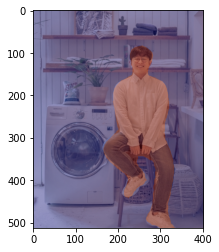

In [7]:
img_show = img_resized.copy()
seg_map = np.where(seg_map == 15, 15, 0) # 예측 중 사람만 추출
img_mask = seg_map * (255/seg_map.max()) # 255 normalization
img_mask = img_mask.astype(np.uint8)
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

사람을 뜻하는 15 외 예측은 0으로 만들었습니다. 그럼 예측된 세그멘테이션 이미지(map)는 최댓값이 15가 됩니다. 일반 이미지는 0부터 255 까지의 값을 사용해 픽셀을 표현하므로, 세그멘테이션 맵에 표현된 값을 원본 이미지에 그림 형태로 출력하기 위해 255로 정규화 합니다. applyColorMap() 함수로 색을 적용하고 이미지를 화면에 출력합니다.

# 8-5. 셸로우 포커스 만들기 (4) 세그멘테이션 결과를 원래 크기로 복원하기

DeepLab 모델을 사용하기 위해 이미지 크기를 작게 resize 해서 입력했습니다. 따라서 출력도 resize 된 입력 크기와 같게 나오게 됩니다.

세그멘테이션 결과(mask)를 원래 크기로 복원해 보겠습니다.

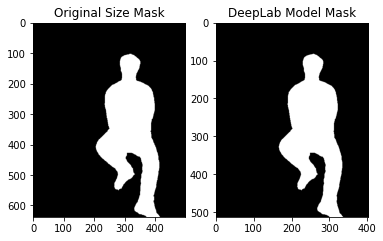

In [8]:
img_mask_up = cv2.resize(img_mask, img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)

ax = plt.subplot(1,2,1)
plt.imshow(img_mask_up, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(img_mask, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()

cv2.resize() 함수를 이용합니다. 크기를 키울 때 보간(interpolation) 을 고려해야 하는데요, cv2.INTER_NEAREST를 이용해서 깔끔하게 처리할 수 있지만 더 정확히 확대하기 위해 cv2.INTER_LINEAR 를 사용합니다. 여기서 보간법(interpolation)은 이미지의 크기를 변경(scaling)하는 과정에서 컴퓨터가 사이사이 픽셀값을 채우는 방법입니다. 자세한 사항은 opencv-python 문서를 참고할 수 있습니다.

결과적으로 img_mask_up 은 경계가 블러된 픽셀값 0~255의 이미지를 얻습니다. 확실한 경계를 다시 정하기 위해 중간값인 128을 기준으로 임계값(threshold)을 설정합니다. 128 이하의 값은 0으로 128 이상의 값은 255로 만드는 방법입니다.

# 8-6. 셸로우 포커스 만들기 (5) 배경 흐리게 하기

이번에는 배경을 흐리게 만듭니다. blur()함수를 이용합니다.

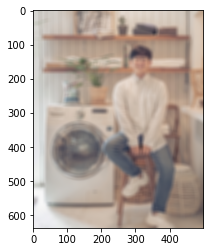

In [9]:
img_orig_blur = cv2.blur(img_orig, (13,13)) #(13,13)은 blurring  kernel size를 뜻합니다. 
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

흐려진 이미지에서 세그멘테이션 마스크를 이용해서 배경만 추출하겠습니다.

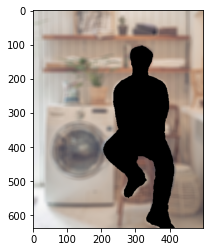

In [10]:
img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

bitwise_not 함수를 이용하면 이미지가 반전됩니다. 배경은 255 사람은 0이 되겠죠? 반전된 세그멘테이션 결과를 이용해서 이미지와 bitwise_and 연산을 수행하면 배경만 있는 영상을 얻을 수 있습니다.

https://stackoverflow.com/questions/32774956/explain-arguments-meaning-in-res-cv2-bitwise-andimg-img-mask-mask

# 8-7. 셸로우 포커스 만들기 (6) 흐린 배경과 원본 영상 합성

이제 배경 영상과 사람 영상을 합치기만 하면 되겠죠?

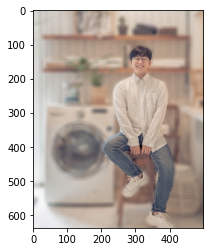

In [12]:
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

세그멘테이션 마스크가 255인 부분만 원본 영상을 가지고 오고 반대인 영역은 블러된 미지 값을 사용합니다.

https://numpy.org/doc/stable/reference/generated/numpy.where.html

# 8-8. 프로젝트: 인물 모드 문제점 찾기
만들면서 뭔가 이상한 점이 느껴지지 않으셨나요? 프로젝트를 통해 찾아봅시다.

Step 1. 인물모드 직접 해 보기
---
- 여러분의 셀카를 이용해서 오늘 배운 내용을 수행해 봅시다. 아래와 같은 이미지를 얻어야 합니다. 최소 3장 이상의 인물모드 사진을 만들어 봅시다.
- 인물이 주인공이 아닌, 귀여운 고양이에 대한 아웃포커싱 사진도 만들어 볼 수 있을 것입니다. 시맨틱 세그멘테이션 스텝에서 힌트를 찾아봅시다.
- 배경을 blur하는 인물모드 사진이 아니라 배경사진을 다른 이미지로 교체하는 크로마키 배경 합성을 시도해 볼 수도 있을 것입니다. 여러분만의 환상적인 사진을 만들어 보면 어떨까요?

Step 2. 사진에서 문제점 찾기
---
그러나 여러분들의 사진에는 무언가 문제점이 있을 것입니다.

아래 사진에도 문제점이 몇 가지 있었습니다. 예를 들어 뒤에 걸린 옷이 인물 영역에 포함되어 blur되지 않고 나온다던가 하는 경우입니다. ㅠㅠ 그 외 다른 문제들이 눈에 띄시나요? 아래 사진에는 이상한 점이 최소 2개 이상 더 있습니다. 어떤 문제가 있는지 찾아서 아래 사진처럼 표시해 봅시다.

추가로 여러분이 만들어 낸 인물 모드 사진 중 하나에서도 이상한 위치를 찾아 아래 사진처럼 표시해 봅시다. 표시한 이미지들을 jupyter notebook에 포함하여 제출해 주세요.

Step 3. 해결 방법을 제안해 보기
---
아주 간단히 멋진 카메라 앱 서비스를 만들어 출시할 수 있을 것 같았지만, 지금 같은 완성도로는 어림도 없습니다. 소비자들의 눈높이는 그리 호락호락하지 않고, 엔지니어인 여러분들은 답을 찾아내야 합니다.

생각해 볼 만한 주제를 아래에 몇 가지 제시해 봅니다. 아래를 읽어본 후, 여러분이 만든 인물모드 사진의 문제점을 해결할 방안을 정리하여 제안해 주시기 바랍니다.
단순히 'XXX 기술을 사용한다.' 정도의 선언적 솔루션이 아니라, 여러분들이 선택한 기술이 DeepLab 모델의 Semantic Segmentation 이 만들어 낸 Mask 영역에 어떻게 적용되어 문제점을 보완하게 되는지의 메커니즘이 포함된 솔루션이어야 합니다.

### 세그멘테이션의 한계

Semantic segmentation의 부정확성이 여러 가지 문제를 발생시키는 주요 원인입니다. 피사계심도를 이용한 보케(아웃포커싱) 효과는 말 그대로 심도를 표현하기 때문에 초점이 잡힌 거리를 광학적으로 아주 섬세하게 구별(segmentation) 하지만 이를 따라 한 semantic segmentation 모듈은 정확도가 1.00 이 되지 않는 한 완벽히 구현하기는 힘듭니다.

### 피사계 심도 이해하기
우선 피사계심도의 개념부터 명확히 이해해 봅시다.

https://ggyul.tistory.com/12

### 3D Depth Camera 활용하기

카메라 2개를 통해 생성한 3d 영상으로 인물모드를 더 정확하게 만들 수 있을까요? 우리는 카메라 1대가 찍은 영상에서 semantic segmentation을 시도하였고, 그 결과가 정확하지 않았습니다. 요즘 스마트폰의 카메라는 렌즈가 2개 달려있지요? 왜 굳이 그렇게까지 하는지 아래 링크를 보면서 이해해 봅시다.

https://m.blog.naver.com/panoptics/221336152952

### 깊이 영상(Depth image) 활용하기

하지만 꼭 카메라가 2개여야 할까요? 아래 이미지는 Struct2Depth 라는 기법을 소개한 Google Brain의 논문에 있는 이미지입니다. 아래 이미지의 세 번째 컬럼이 보다 명확하게 depth에 따른 물체인식을 보여 주는데, 이것은 LiDAR가 없이도 아주 정확한 segmentation을 동반한 depth sensor가 가능함을 보여줍니다.

https://towardsdatascience.com/depth-prediction-autonomous-driving-18d05ff25dd6  
https://sites.google.com/view/struct2depth